# About this notebook

In this notebook, we apply CIDRE to a network with communities and demonstrate how to use CIDRE and visualize the detected groups.

To start, we'll need some basic libraries.


In [1]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre

Next, we load a network to test CIDRE. 

In [2]:
# Data path
edge_file = "../data/synthe/edge-table.csv"
node_file = "../data/synthe/node-table.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

A key feature of CIDRE is to filter out community structure that overshadow anomalous groups in networks. Here, we use `graph-tool` package to get the community membebership of nodes. 

First of all, install `graph-tool` by 

In [3]:
!conda install -y -c conda-forge graph-tool

Solving environment: done

# All requested packages already installed.



Now, let's detect communities using `graph-tool`. We fit the degree-corrected stochastic block model (dcSBM) to the network and consider each block as a community. Here we limit the number of communities to be less than three. This is crucial because otherwise the stochastic block model may overfit to the anomalous groups, i.e., anomalous groups might be detected as communities.


In [58]:
import graph_tool.all as gt
def detect_community(A, K = None, **params):
    """Detect communities using graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities
    :type K: int
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]

In [59]:
group_membership = detect_community(A, K = 3) 

Now, we input a network and its community structure to CIDRE. TO this end, create `cidre.Cidre` object and pass `group_membership` along with some key parameters.

In [55]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.05, min_edge_weight = 1)

- `alpha` (default 0.01) is the statistical significance level.
- `min_edge_weight` is the threshold of the edge weight, i.e., the edges with weight less than this value will be removed.

Then, pass the network in form of `scipy.sparse_csr` matrix or `nx.Graph`.

In [52]:
groups = alg.detect(A, threshold=0.15)

`groups` is a list of `Group` instance. We can get the donor nodes of a group, for example `groups[0]`, by 

In [53]:
groups[0].donors

{82: 0.2807017543859649, 89: 0.3532608695652174}

The keys and values of this dict object are the IDs of the nodes and their donor scores, respectively. The recipients and their recipient scores can be obtained by 

In [7]:
groups[0].recipients

{0: 0.29357798165137616, 14: 0.20930232558139536, 55: 0.3671875}

# Visualization 

`cidre` package provides an API to visualize small groups. To use this API, first of all, we need some additional libraries.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

Then plot the group by

<AxesSubplot:>

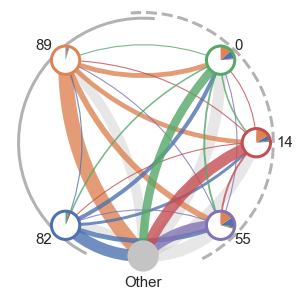

In [9]:
# The following three lines are purely for visual enhancement, i.e., changing the saturation of the colors and font size.
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Set the figure size
width, height = 5,5
fig, ax = plt.subplots(figsize=(width, height))

# Plot a citation group
cidre.DrawGroup().draw(groups[0], ax = ax)